In [1]:
%run init.ipynb

In [2]:
from qiskit import *

# O experimento da bomba de Elitzur e Vaidman
Consideremos o experimento de Mach-Zehnder, com uma bomba sensível a um único fóton colocada no caminho vertical, depois do espelho. Veja a figura abaixo.
<img src = 'fig_bomba.png' width = '300'>

Ao passar pelo divisor de feixes, o fóton é colocado em um estado de superposição, seguindo pelos dois caminhos. A bomba funciona como um detector. Então, com probabilidade $1/2$ esta explodirá e com probabilidade 1/2 não acontecerá nada. 

No caso do estado de posição do fóton colapsar para o caminho onde a bomba não está, quando o fóton chegar ao segundo divisor de feixes, terá também 50% de chance de ser ou não ser refletido. Quando comparado ao caso em que a bomba não existe, para o qual 
$$Pr(1)=0, \text{sem a bomba.}$$
quando a bomba está presente, teremos uma probabilidade
$$(1/2)(1/2) = 1/4 = Pr(1), \text{com a bomba,}$$
de detectarmos a bomba sem explodí-la.

Esse efeito foi chamado de __medida livre de interação__, pois detectamos a presença da bomba sem o fóton ter interagido com ela (embora essa afirmação seja discutível). Também chama-se esse tipo de fenômeno de contra-factual. Alguns usam esse experimento para argumentar que a interpretação de muitos mundos de Everett seria adequada para explicar o que acontece aqui (a bomba explode, mas as vezes explode em outro universo).

Vamos simular o processo de medida da bomba a tratando como um qubit que se emaranha com o fóton. Ou seja, identificamos
\begin{cases}
|0\rangle \equiv \text{ bomba não explodiu}, \\
|1\rangle \equiv \text{ bomba explodiu}.
\end{cases}
Inicialmente a bomba está no estado $|0\rangle$. O processo de medida da bomba atua como a placa de quarto de onda, que vimos quando da discussão sobre o apagador quântico. Ou seja
$$U_{b} = |0\rangle\langle0|\otimes I + |1\rangle\langle 1|\otimes X.$$
Como o estado do fóton imediatamente antes da bomba é
$$(-|0\rangle+i|1\rangle)/\sqrt{2},$$
depois que a bomba atua, teremos o estado
$$U_{b}(-|0\rangle_{f}+i|1\rangle_{f})|0\rangle_{b}/\sqrt{2} = (-|00\rangle_{fb}+i|11\rangle_{fb})/\sqrt{2}.$$
Finalmente, atuando o último divisor de feixes obteremos o estado
\begin{align}
& \frac{1}{2}\big(-(|0\rangle_{f}+i|1\rangle_{f})|0\rangle_{b}+i(i|0\rangle_{f}+|1\rangle_{f})|1\rangle_{b})\big) \\
& = \frac{1}{2}\big(-|00\rangle_{fb}-i|10\rangle_{fb}-|01\rangle_{fb}+i|11\rangle_{fb}\big).
\end{align}
Assim, a probabilidade de do fóton chegar em D1 e a bomba não explodir é
$$Pr(10) = |c_{10}|^{2} = |-i/2|^{2} = \frac{1}{4}.$$

Abaixo está a implementação do experimento da bomba de Elitzur-Vaidman usando o IBMQ.

In [33]:
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
nshots = 8192
qiskit.IBMQ.load_account()
provider = qiskit.IBMQ.get_provider(hub = 'ibm-q-research-2', group = 'federal-uni-sant-1', project = 'main')
simulator = Aer.get_backend('qasm_simulator')
device = provider.get_backend('ibmq_bogota')
from qiskit.tools.monitor import job_monitor
from qiskit.tools.visualization import plot_histogram

ibmqfactory.load_account:WARNING:2022-01-11 18:24:31,565: Credentials are already in use. The existing account in the session will be replaced.


In [28]:
def qc_df():
    qc = QuantumCircuit(1, name = 'DF')
    qc.s(0); qc.h(0); qc.s(0)
    return qc
qc_df_ = qc_df(); qc_df_.draw()

┌───┐┌───┐┌───┐
q_0: ┤ S ├┤ H ├┤ S ├
     └───┘└───┘└───┘

In [40]:
def qc_bomb():
    qc = QuantumCircuit(2, name='bomba')
    qc.cx(0,1)
    return qc
qc_bomb_ = qc_bomb(); qc_bomb_.draw()

q_0: ──■──
     ┌─┴─┐
q_1: ┤ X ├
     └───┘

In [41]:
def qc_espelho():
    qc = QuantumCircuit(1, name='espelho')
    qc.z(0); qc.y(0)
    return qc
qc_espelho_ = qc_espelho(); qc_espelho_.draw()

┌───┐┌───┐
q_0: ┤ Z ├┤ Y ├
     └───┘└───┘

In [42]:
qc = QuantumCircuit(2, 2)
qc_df_ = qc_df(); qc.append(qc_df_, [0])
qc_espelho_ = qc_espelho(); qc.append(qc_espelho_, [0])
qc_bomb_ = qc_bomb(); qc.append(qc_bomb_, [0,1])
qc.append(qc_df_, [0]); qc.barrier()
qc.measure([0,1],[0,1])
qc.draw()

┌────┐┌─────────┐┌────────┐┌────┐ ░ ┌─┐   
q_0: ┤ DF ├┤ espelho ├┤0       ├┤ DF ├─░─┤M├───
     └────┘└─────────┘│  bomba │└────┘ ░ └╥┘┌─┐
q_1: ─────────────────┤1       ├───────░──╫─┤M├
                      └────────┘       ░  ║ └╥┘
c: 2/═════════════════════════════════════╩══╩═
                                          0  1

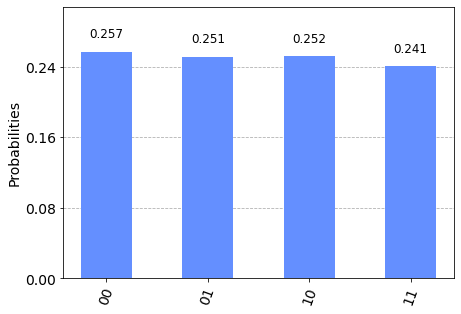

In [43]:
job = qiskit.execute(qc, backend = simulator, shots = nshots)
plot_histogram(job.result().get_counts(qc))

In [44]:
job = qiskit.execute(qc, backend = device, shots = nshots)
print(job.job_id()); job_monitor(job)

61def0fd87d4f857d12400e2
Job Status: job has successfully run


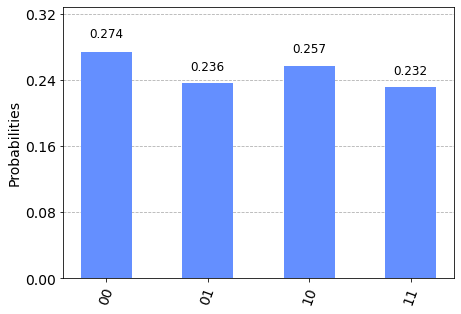

In [45]:
plot_histogram(job.result().get_counts(qc))

Esse conceito de medida livre de interação é realmente interessante. Podemos pensar e.g. e fazer uma imagem de raios X "sem" jogar raiox X sobre a amostra (evitando câncer, por exemplo). A seguir discutiremos uma maneira de chegar mais próximo do "sem". 

## Divisor de feixes geral
Ao invés de considerar um divisor de feixes (DF) com refletividade 50%, vamos considerar um divisor de feixes com uma refletividade geral (DFG). Temos que
\begin{cases}
R^{2} = \text{ probabilidade do fóton ser refletido} = \text{ taxa temporal de fótons refletidos}, \\
T^{2} = \text{ probabilidade do fóton ser transmitido} = \text{ taxa temporal de fótons transmitidos}.
\end{cases}
Devemos ter portanto
$$R^{2}+T^{2}=1.$$

Neste caso geral, o efeito do DFG será
\begin{cases}
|0\rangle \rightarrow T|0\rangle+iR|1\rangle, \\
|1\rangle \rightarrow T|1\rangle+iR|0\rangle.
\end{cases}
Com isso, vem que
\begin{align}
U_{dfg}|\psi\rangle & = \begin{bmatrix}U_{11}&U_{12}\\U_{21}&U_{22}\end{bmatrix}\begin{bmatrix}c_{0}\\c_{1}\end{bmatrix} \\
& = c_{0}U_{dfg}|0\rangle + c_{1}U_{dfg}|1\rangle =  c_{0}(T|0\rangle+iR|1\rangle) + c_{1}(T|1\rangle+iR|0\rangle) \\
& = (Tc_{0}+iRc_{1})|0\rangle + (iRc_{0}+Tc_{1})|1\rangle = \begin{bmatrix}Tc_{0}+iRc_{1}\\iRc_{0}+Tc_{1}\end{bmatrix}.
\end{align}
Portanto
$$U_{dfg} \doteq \begin{bmatrix}T&iR\\iR&T\end{bmatrix} =: \begin{bmatrix}\cos\theta&i\sin\theta\\i\sin\theta&\cos\theta\end{bmatrix} = U_{dfg}(\theta).$$

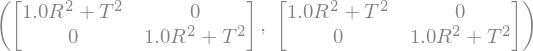

In [47]:
T, R = symbols('T R'); Udfg = Matrix([[T,1j*R],[1j*R,T]]); Udfgd = Matrix([[T,-1j*R],[-1j*R,T]])
Udfg*Udfgd, Udfgd*Udfg # ok, é unitária

Claro, teremos o caso especial 
$$U_{df} = U_{dfg}(\theta = \pi/4) = U_{dfg}(T = R = 1/\sqrt{2}).$$

Ademais, como 
$$RX(\theta) = e^{-iX\theta/2} = \begin{bmatrix}\cos(\theta/2)&-i\sin(\theta/2)\\-i\sin(\theta/2)&\cos(\theta/2)\end{bmatrix},$$
temos que
$$ U_{dfg}(\theta) = RX(-2\theta).$$

### Mach-Zehnder com divisor de feixes geral
Considere o interferômetro de Mach-Zehnder (IMZ) da figura abaixo, mas os divisores de feixes (DFs) gerais.
<img src='fig_imz.png' width='300'>
Teremos a seguinte sequência de estados
\begin{align}
& |0\rangle \stackrel{DFG}{\longrightarrow} \cos\theta|0\rangle + i\sin\theta|1\rangle  \\
& \stackrel{E}{\longrightarrow} i\cos\theta|1\rangle + i^{2}\sin\theta|0\rangle \\
& \stackrel{\phi}{\longrightarrow} ie^{i\phi}\cos\theta|1\rangle - \sin\theta|0\rangle \\
& \stackrel{DFG}{\longrightarrow} ie^{i\phi}\cos\theta(\cos\theta|1\rangle+i\sin\theta|0\rangle) - \sin\theta(\cos\theta|0\rangle+i\sin\theta|1\rangle) \\
& = -\sin\theta\cos\theta(1+e^{i\phi})|0\rangle +i\big(e^{i\phi}\cos^{2}\theta-\sin^{2}\theta\big)|1\rangle.
\end{align}
Assim
$$Pr(D_{0}) = \sin^{2}\theta\cos^{2}\theta|1+e^{i\phi}|^{2} = 2\sin^{2}\theta\cos^{2}\theta(1+\cos\phi)$$
e
\begin{align}
V = \frac{P_{\max}-P_{\min}}{P_{\max}+P_{\min}} = \frac{2\sin^{2}\theta\cos^{2}\theta - 0}{2\sin^{2}\theta\cos^{2}\theta + 0}.
\end{align}

## Diminuindo a probabilidade da bomba explodir

Para referência, se aplicarmos 2 vezes o DFG, teremos
\begin{align}
U_{dfg}(\theta)U_{dfg}(\phi) & = \begin{bmatrix}\cos\theta&i\sin\theta\\i\sin\theta&\cos\theta\end{bmatrix}\begin{bmatrix}\cos\phi&i\sin\phi\\i\sin\phi&\cos\phi\end{bmatrix} \\
& = \begin{bmatrix}\cos\theta\cos\phi-\sin\theta\sin\phi & i(\sin\theta\cos\phi+\cos\theta\sin\phi) \\ i(\sin\theta\cos\phi+\cos\theta\sin\phi) & \cos\theta\cos\phi-\sin\theta\sin\phi\end{bmatrix} \\
& = \begin{bmatrix} \cos(\theta+\phi) & i\sin(\theta+\phi) \\ i\sin(\theta+\phi) & \cos(\theta+\phi) \end{bmatrix}  = U_{dfg}(\theta+\phi).
\end{align}
OBS: Embora isso não pareça importar aqui, observo que $U_{dfg}(\theta)$ formam um grupo $\big(e=U_{dfg}(0)$, $U_{dfg}^{-1}(\theta)=U_{dfg}(-\theta)\big)$. <br>
Para o DF, teremos
$$U_{df}U_{df} = U_{dfg}(\pi/4)U_{dfg}(\pi/4) = U_{dfg}(\pi/2).$$
Notemos que essas são as duas operações mais importantes no IMZ, uma cria superposição e a outra faz com que haja interferência entre os diferentes caminhos. 